# Lab 07

### <span style="color:chocolate"> Submission requirements </span>

Your homework will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Step 1: Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "./EuroSAT" # replace with your path

2024-03-03 18:02:26.100490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 2: Read data

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the `load_data` function according to the following guidelines:
- to read label and image names: use the os library (in particular the os.listdir() and os.path.join() methods)
- to load an image: use the load_image() method (see list of imported libraries)
- to transform images to arrays: use the img_to_array() method (see list of imported libraries)

In [2]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    # create empty lists to store images and labels
    images = []
    labels = []

    # load images and labels
    for folder in os.listdir(path_to_data):
        # if folder is not a file
        if not os.path.isfile(os.path.join(path_to_data, folder)):
            for file in os.listdir(os.path.join(path_to_data, folder)):
                if file.endswith(".jpg"):
                    img = load_img(os.path.join(path_to_data, folder, file))
                    img = img_to_array(img)
                    images.append(img)
                    labels.append(folder)
                else:
                    continue
    
    # convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [3]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


---
### Step 3: Inspect data

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

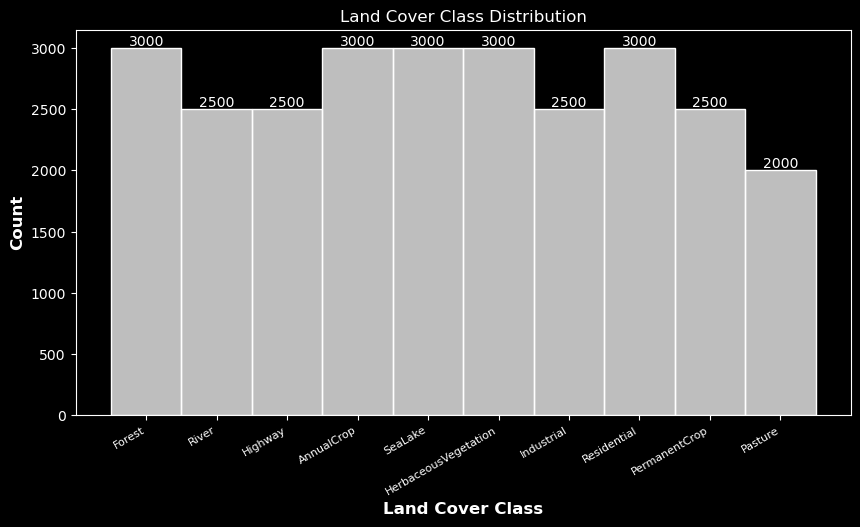

In [4]:
# FILL IN CODE HERE
# Create a histogram of the class distribution
plt.figure(figsize=(10, 5))
ax = sns.histplot(labels, kde=False, color='white')
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.xticks(rotation=30, ha='right', fontsize=8)
plt.xlabel('Land Cover Class', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Land Cover Class Distribution')
plt.show()

Comment on class balance: *Overall, the distribution of classes across the dataset is fairly balanced, with most classes having either 3000 or 2500 images with the repsective labels. The 'pasture' class, however, has a slightly lower representation with 2000 images with the pasture label across the dataset.*

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

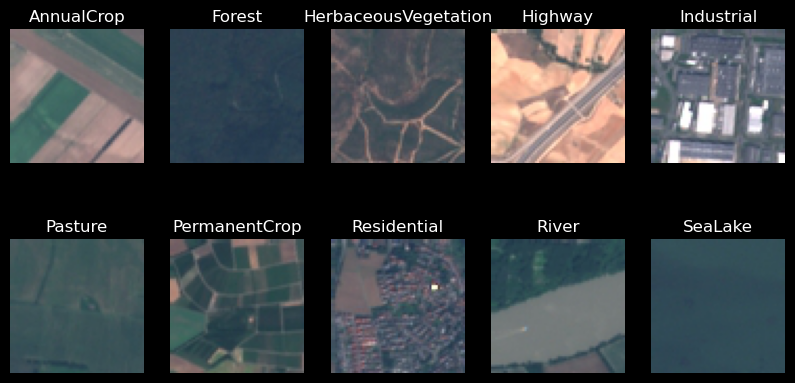

In [5]:
# FILL IN CODE HERE #
land_class = np.unique(labels)

# print the first image of each class and their corresponding labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()
for i in range(len(land_class)):
    axes[i].imshow(images[labels == land_class[i]][0].astype(int))
    axes[i].set_title(land_class[i])
    axes[i].axis('off')

Most confused land classes: *There is likely to be confusion with the 'AnnualCrop' and 'PermanentCrop' classes as both have a linear pattern with green and tan colors. There is some risk that 'HerbaceousVegetation' may also cause some confusion with the two crop classes, but the 'HerbaceousVegetation' class appears in this example to have less linear distiction in land areas, which may help offset mis-classification. There may also be some confusion between 'Forest' and 'Pasture' as both have a great deal of green. Forest does not have as much of a linear pattern as pasture does, so the confusion may be partially offset by that feature. Finally, there may be some challenges in differentiating between 'Industrial' and 'Residential' given both have many small buildings that are similarly shaped.* 

---
### Step 4: Preprocess data

Encode labels

In [6]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the `split_data` function according to the following guidelines:
- shuffle images and labels before spliting the data
- use a 60/20/20 split

In [7]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    # shuffle data
    indices = np.arange(images.shape[0])
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
    
    # create data splits
    # Create a train, validation, and test datasets using the ratio in the split variable.
    X_train, X_val, X_test = np.split(images, [int(split[0]*len(images)), int((split[0]+split[1])*len(images))])
    y_train, y_val, y_test = np.split(labels, [int(split[0]*len(images)), int((split[0]+split[1])*len(images))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [8]:
# Define splits
split = (0.6, 0.2, 0.2)

# Create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# Print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


In [9]:
# Get the breakout of classes in the train, val, and test sets
# Ensure that the class distribution is similar across the train, val, and test sets
y_train_num_class = np.unique(y_train, return_counts=True)
y_val_num_class = np.unique(y_val, return_counts=True)
y_test_num_class = np.unique(y_test, return_counts=True)

print('Train set class distribution: ', y_train_num_class)
print('Val set class distribution: ', y_val_num_class)
print('Test set class distribution: ', y_test_num_class)

Train set class distribution:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1822, 1821, 1784, 1497, 1466, 1197, 1499, 1815, 1468, 1831]))
Val set class distribution:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([585, 609, 606, 503, 522, 403, 491, 607, 493, 581]))
Test set class distribution:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([593, 570, 610, 500, 512, 400, 510, 578, 539, 588]))


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the `data_preprocessing()` function according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module).
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels.
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [10]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N_train, 64, 64, 3)
    y (np.ndarray): Labels of shape (N_train,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness of each pixel by adding delta
        # create a new variable X_augm to store the augmented images
        X_augm = tf.image.adjust_brightness(X, DELTA).numpy()

        # adjust the contrast of each pixel by adding a contrast factor
        # update X_augm to store the augmented images
        X_augm = tf.image.adjust_contrast(X_augm, CONTRAST_FACTOR).numpy()

        # random flip left and right
        # update X_augm to store the flipped images
        X_augm = tf.image.random_flip_left_right(X_augm).numpy()

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm],axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y_train
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor
        
        
    # rescale image by dividing each pixel by 255.0 
    X = X / 255.0
    
    return X, y

Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): *Augmenting the training data allows for the model to be fit on a broader range of potential images. More specifically, it ensure that the model is trained on the 'edge cases' as well. Ultimately, this approach will allow for the model to generalize better. To test that generalization, we evaluate the validating and test data. If the augmentation of the training data produces better generalization on the model, you will see better metrics in the validation and eventually the test dataset.* 

In [11]:
# Apply data preprocessing
X_train_proc, y_train_proc = data_preprocessing(X_train, y_train, data_partition='train')
X_val_proc, y_val_proc = data_preprocessing(X_val, y_val, data_partition='val')
X_test_proc, y_test_proc = data_preprocessing(X_test, y_test, data_partition='test')

# Print shapes
print('Shape of train images ', X_train_proc.shape)
print('Shape of train labels ', y_train_proc.shape)
print('Shape of val images ', X_val_proc.shape)
print('Shape of test images ', X_test_proc.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [12]:
# Compute number of features (multiply RGB features)
features_shape = X_train_proc[:, :, :, 0].shape[1] * X_train_proc.shape[2] * X_train_proc.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# Reshape data
X_train_re = X_train_proc.reshape(X_train_proc.shape[0], features_shape)
X_val_re = X_val_proc.reshape(X_val_proc.shape[0], features_shape)
X_test_re = X_test_proc.reshape(X_test_proc.shape[0], features_shape)

# Print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train_proc.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 5: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the RandomForestClassifier class available in the sklearn.ensemble module
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on the validation dataset. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

In [13]:
### YOUR CODE HERE ###
# Create a Random Forest Classifier with the baseline classifier parameters as follows:
# n_estimators=2, n_jobs=1, max_depth=8, random_state=7
forest_model = ensemble.RandomForestClassifier(n_estimators=2, n_jobs=1, max_depth=8, random_state=7)

In [14]:
# Fit the model on the training data
forest_model.fit(X_train_re, y_train_proc)

# Predict the labels on the training and validation data
y_train_pred = forest_model.predict(X_train_re)
y_val_pred = forest_model.predict(X_val_re)

In [15]:
# Evaluate the accuracy of the model on the training and validation data
train_accuracy = accuracy_score(y_train_proc, y_train_pred)
val_accuracy = accuracy_score(y_val_proc, y_val_pred)
print('Training accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)

Training accuracy: 0.4825925925925926
Validation accuracy: 0.4451851851851852


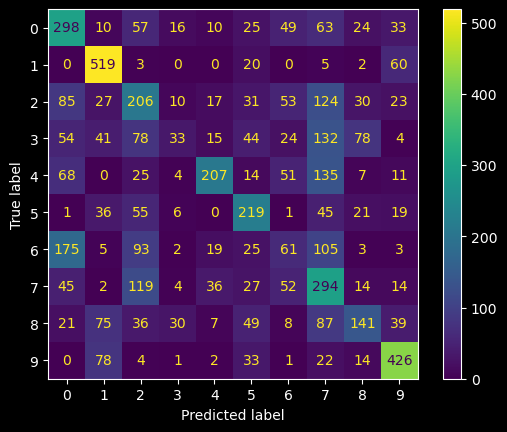

In [16]:
# Plot the confusion matrix for the validation dataset
confusion_matrix_val = confusion_matrix(y_val_proc, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix_val).plot()

In [17]:
# Get the class with the highest inaccuracy

list_of_inaccurate_class_pred = []

# Get the class with the highest inaccuracy
for i in range(len(confusion_matrix_val)):
    for j in range(len(confusion_matrix_val)):
        if i != j and confusion_matrix_val[i, j] > 0:
            list_of_inaccurate_class_pred.append((i, j, confusion_matrix_val[i, j]))

list_of_inaccurate_class_pred = sorted(list_of_inaccurate_class_pred, key=lambda x: x[2], reverse=True)

# Replace the numbers with the class names based on the encoder
list_of_inaccurate_class_pred = [(encoded_labels_classes[i], encoded_labels_classes[j], count) for i, j, count in list_of_inaccurate_class_pred]

# Print the top 3 prediction pairs with the highest inaccuracy
print('The top 3 prediction pairs with the highest inaccuracy are (True Label, Predicted Lable, Number of Times): ', list_of_inaccurate_class_pred[:3])


The top 3 prediction pairs with the highest inaccuracy are (True Label, Predicted Lable, Number of Times):  [('PermanentCrop', 'AnnualCrop', 175), ('Industrial', 'Residential', 135), ('Highway', 'Residential', 132)]


Comment on model accuracy on validation data: *The model's accuracy is poor, with an accuracy of .45. This suggest that the model provides an accurate prediction a little less than half the time, meaning it is less useful than a coin-flip. Of note, the accuracy on the training data is also low, which suggests that the model is not fitting to the data well and/or that we need to update our model characteristics to better suit the data.*

Does the model generalize well?: *Given the low accuracy rate of the model on the validation data set as well as the original training data set, it is safe to assess that the model is not generalizing well at all.* 

Comment on the classes that the model confuses the most: *Given the confusion matrix, it appears as though the model has challenges with differentiating between class PermanentCrop and AnnualCrop, class Industrial and Residential, as well as class Highway and Residential. This aligns mostly to the original prediction of potential challenges with the exception of Highway and Residential, which was not originally included. If able to do further analysis, it would be interesting to see if these 132 images of Highway that were incorrectly predicted as Residential also had buildings in the images. If so, then it would indicate that the model weighs the geometric images of a house or building higher than the smooth path of a road/highway.*

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). The model should also generalize well (the performance difference between the training and validation sets should be at most 10%). Also, be sure to follow these guidelines: 
    
- Use the RandomForestClassifier or the GradientBoostingClassifier available in the sklearn.ensemble module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on validation performance relative to baseline model.
- Does your model generalize well (compare accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data).
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

In [34]:
rf_clf2 = ensemble.RandomForestClassifier(n_estimators=45, n_jobs=1, max_depth=8, random_state=7)
### YOUR CODE HERE ###

# Fit the model on the training data
model_2 = rf_clf2.fit(X_train_re, y_train_proc)

# Predict the labels on the training and validation data
y_train_pred_mod2 = model_2.predict(X_train_re)
y_val_pred_mod2 = model_2.predict(X_val_re)

# Evaluate the accuracy of the model on the training and validation data
train_accuracy_mod2 = accuracy_score(y_train_proc, y_train_pred_mod2)
print('Training accuracy:', train_accuracy_mod2)

val_accuracy_mod2 = accuracy_score(y_val_proc, y_val_pred_mod2)
print('Validation accuracy:', val_accuracy_mod2)


Training accuracy: 0.6342592592592593
Validation accuracy: 0.5466666666666666


In [29]:
# Analyze the new model to see if the areas of issue have improved
confusion_matrix_val = confusion_matrix(y_val_proc, y_val_pred_mod2)

list_of_inaccurate_class_pred = []

# Get the class with the highest inaccuracy
for i in range(len(confusion_matrix_val)):
    for j in range(len(confusion_matrix_val)):
        if i != j and confusion_matrix_val[i, j] > 0:
            list_of_inaccurate_class_pred.append((i, j, confusion_matrix_val[i, j]))

list_of_inaccurate_class_pred = sorted(list_of_inaccurate_class_pred, key=lambda x: x[2], reverse=True)

# Replace the numbers with the class names based on the encoder
list_of_inaccurate_class_pred = [(encoded_labels_classes[i], encoded_labels_classes[j], count) for i, j, count in list_of_inaccurate_class_pred]

# Print the top 3 prediction pairs with the highest inaccuracy
print('The top 3 prediction pairs with the highest inaccuracy are (True Label, Predicted Lable, Number of Times): ', list_of_inaccurate_class_pred[:3])

The top 3 prediction pairs with the highest inaccuracy are (True Label, Predicted Lable, Number of Times):  [('PermanentCrop', 'AnnualCrop', 183), ('Highway', 'Residential', 177), ('Industrial', 'Residential', 135)]


How your implementation is different compared to the baseline classifier: *The differences between these two models is the baseline model. Both use the RandomForestClassifier, but the original model uses the following parameters: n_estimators=2, n_jobs=1, max_depth=8, random_state=7. The new model increases the number of estimators to 45 to allow for a greater number of trees with the hopes of better distinguishing between the three class pairs that the original model struggled to distinguish between. Of note, increasing the estimators or the depth would improve the training accuracy, but the difference between training and validation accuracy was greater than 10% difference indicating model overfit.*

Comment on validation performance relative to baseline model: *The performance on the validation set has not improved significantly, increasing from a .445 to a .547. This suggests that either the model is not appropriate for this data set or that additional preprocessing on the image is ideal. Of note, an attempt at using a pre-processing technique for edge detection called 'canny' was used and it resulted in no changes to the accuracy of the model. Given the type of data (e.g. different aspect/angles, and objects being different sizes from images to image such as a house), the amount of preprocessing that would be required to resolve these differences would be extremely cubersome.*

Does the model generalize well? *It does not appear that there is a significant issue with overfitting, as the difference between the accuracy of the training dataset and the validation dataset is less than .10. That said, given the overall accuracy is only slightly above 0.547, the model has improved but is still not very good at generalizing.*

Comment on the classes the model confuses the most relative to the baseline: *The new model continues to struggle in distinguishing between the same class pairs. In fact, the errors between these two classes actually increase despite the model accuracy against the validation set slightly increasing. Again, this suggests that greater preprocessing is needed but more likely a different model would be more useful to help distinguish between these class pairs. There is the option of additional feature engineering, looking at the specific features and removing any that are not beneficial to differentiation.*

---
### Step 6: Evaluation (on test data)

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the validation set?

In [46]:
### YOUR CODE HERE ###
y_test_pred_mod2 = model_2.predict(X_test_re)

# Evaluate the accuracy of the model on the test data
test_accuracy_mod2 = accuracy_score(y_test_proc, y_test_pred_mod2)
print('Test accuracy:', test_accuracy_mod2)

Test accuracy: 0.5298148148148148


Comment on test set accuracy vs. validation set accuracy: *Not surprisingly, the accuracy of the model using the test dataset is slightly lower than that of the validation data set. Consequently, the model performs fairly consistently but fails to produce a very strong accuracy or generalization.*

---
### Step 7: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

*Given the data set, there are so many similar features across different classes and there is no consisency in the image size or relative features (e.g. a house in one image may be larger than a house in the other based on how aspect/angle that the satellite took the image). Adjusting for these differences will be challenging even in preprocessing, and thus a decision forest classifier is likely not the most ideal.*

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

*Given this is an image classifier, I would recommend using a Convolutional Neural Network for edge detection and then classification. It is clear that the random forest classification model does not perform as well on images that have several similar characteristics. Using a neural network as well with multiple hidden layers may provide better ability to detect and differentiate between non-linear features in the image. There is a strong likelihood, however, that even with a neural network, there will be challenges distinquishing between 'PermanentCrop' and 'AnnualCrop' as well as 'Industrial' and 'Residential'. Thus, feature engineering may also yield higher accuracy.* 

#### <span style="color:chocolate"> Bonus Exercise (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [50]:
### YOUR CODE HERE ###

# Create a new model using a convolutional neural network
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model (only 6 epochs based on previous testing in which once you got to 7, the model started overfitting)
history = model.fit(X_train_proc, y_train_proc, epochs=6, 
                    validation_data=(X_val_proc, y_val_proc))

# Evaluate the model on the training and validation data
train_loss, train_accuracy = model.evaluate(X_train_proc, y_train_proc, verbose=2)
val_loss, val_accuracy = model.evaluate(X_val_proc, y_val_proc, verbose=2)
print('Training accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)

Epoch 1/6
1013/1013 [==============================] - 230s 201ms/step - loss: 1.1496 - accuracy: 0.5790 - val_loss: 1.0346 - val_accuracy: 0.6246
Epoch 2/6
1013/1013 [==============================] - 203s 200ms/step - loss: 0.7205 - accuracy: 0.7370 - val_loss: 0.6686 - val_accuracy: 0.7591
Epoch 3/6
1013/1013 [==============================] - 208s 206ms/step - loss: 0.5575 - accuracy: 0.7998 - val_loss: 0.5420 - val_accuracy: 0.8083
Epoch 4/6
1013/1013 [==============================] - 183s 181ms/step - loss: 0.4581 - accuracy: 0.8374 - val_loss: 0.5932 - val_accuracy: 0.7967
Epoch 5/6
1013/1013 [==============================] - 191s 189ms/step - loss: 0.3829 - accuracy: 0.8626 - val_loss: 0.4771 - val_accuracy: 0.8369
Epoch 6/6
1013/1013 [==============================] - 221s 218ms/step - loss: 0.3157 - accuracy: 0.8876 - val_loss: 0.4639 - val_accuracy: 0.8398
1013/1013 - 54s - loss: 0.2762 - accuracy: 0.9021 - 54s/epoch - 54ms/step
169/169 - 8s - loss: 0.4639 - accuracy: 0.83

In [51]:
# Evaluate the accracy of the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test_proc, y_test_proc, verbose=2)
print('Test accuracy:', test_accuracy)


169/169 - 7s - loss: 0.4866 - accuracy: 0.8307 - 7s/epoch - 42ms/step
Test accuracy: 0.830740749835968
